In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units
#from dustmaps.bayestar import BayestarWebQuery
import numpy as np
import os
from bokeh.plotting import *
output_notebook()
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers
from astropy.modeling.models import KingProjectedAnalytic1D
from astropy.modeling import models, fitting
import scipy.optimize
import scipy.stats as stats
import hdbscan
#from dustmaps.config import config
#config.reset()

Loading BokehJS ...

NGC_2682
Prior distance =  869.0142857142854  pc


Radius for HDBSCAN? (in degrees) .5
Min cluster size? 150


1585  members in group  -1
1501  members in group  0
316  members in group  1


Which group? 0


Cluster distance =  865.013435073385  pc


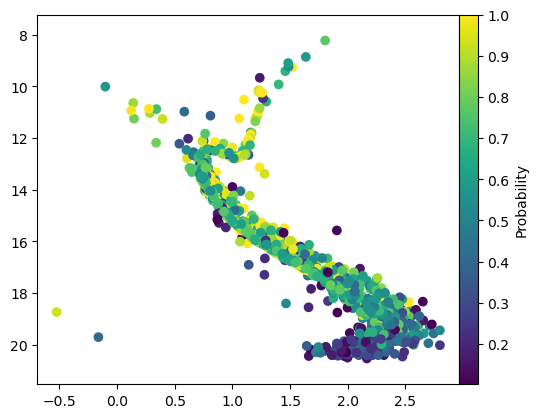

Use this group? (y/n)? y


Length of members =  1486
fit parameters :
amplitude = 4.48 +/- 0.521
r_core = 5.48 +/- 0.411
r_tide = 1.6e+02 +/- 7.55
done.


<Figure size 640x480 with 0 Axes>

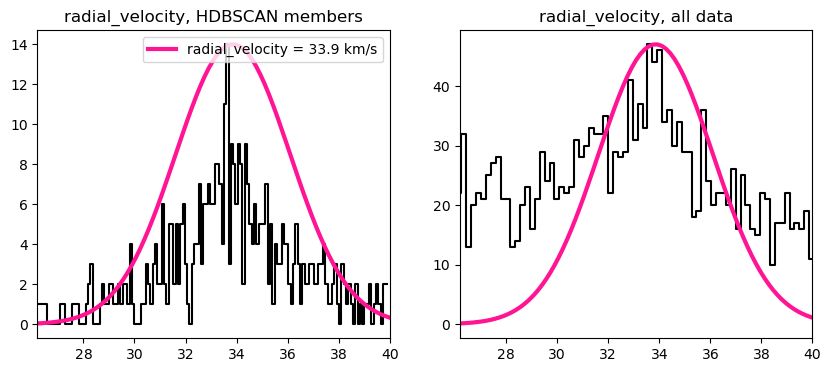

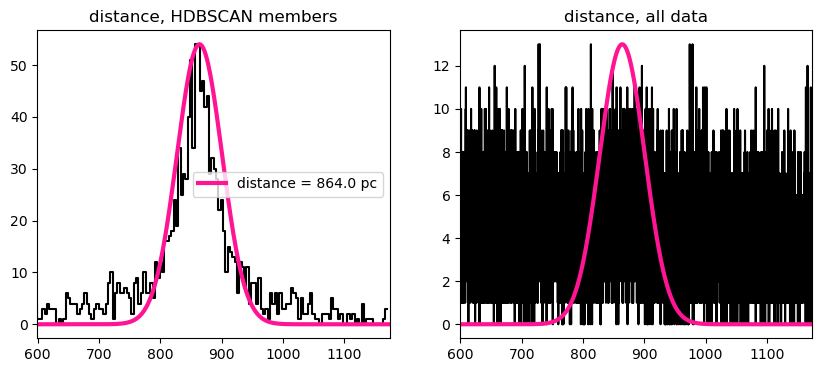

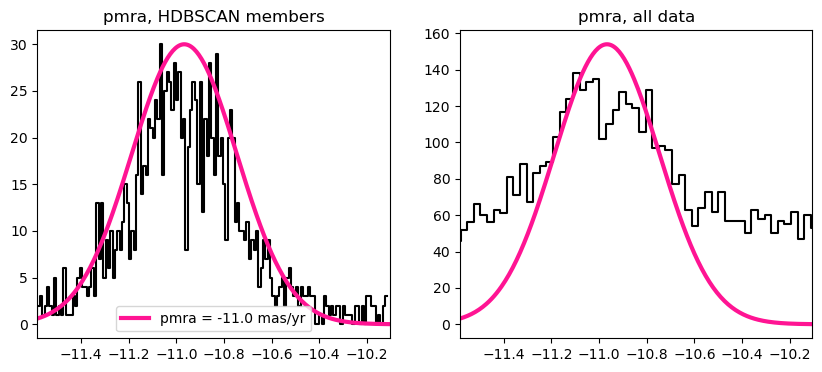

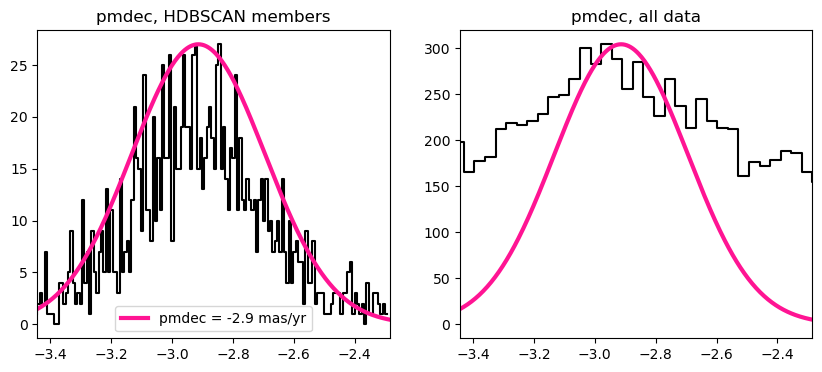

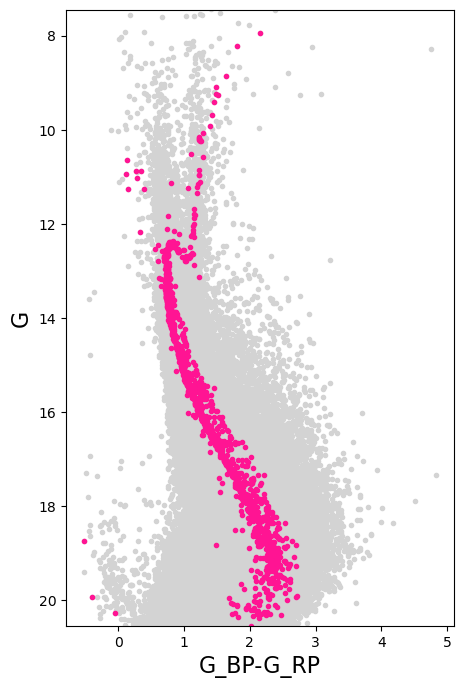

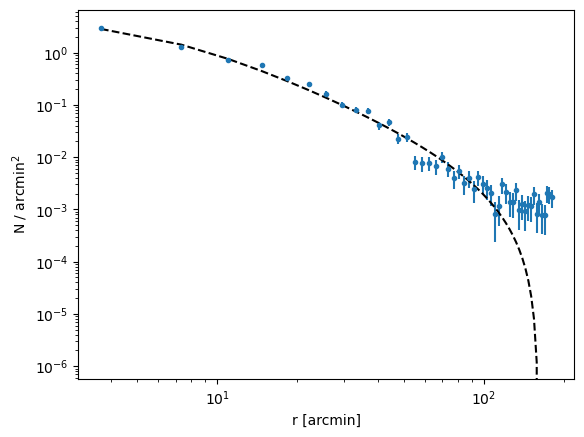

In [2]:
OCdf = pd.read_csv('OCcompiled_clean_v2.csv') #file with prior values for cluster centers from previous literature
Hunt = pd.read_csv('Hunt2023.tsv',sep='\s+', header=94)

def distance_modulus_to_pc(distance_modulus):
    return 10 ** ((distance_modulus + 5) / 5)

#def run_pipeline(clusterName):
clusterName = 'NGC_2682'
print (clusterName)
cluster = GaiaClusterMembers()
pwd = 'OC_data/'+clusterName+'_dir'
try:
    os.makedirs(pwd)
    os.makedirs(pwd+'/plots')
except:
    next
cluster.plotNameRoot = pwd+'/plots/'
cluster.photOutputFileName = pwd +'/'+clusterName + '.phot'
cluster.saveDataFile = pwd +'/'+clusterName + '.csv'
cluster.yamlOutputFileName = pwd + '/base9.yaml'
cluster.yamlTemplateFileName = 'template_base9.yaml'

try:
    row = OCdf.loc[OCdf['ID'] == clusterName].iloc[0]
    Mg = 1.5*10**12 #*units.solMass #this probably could use verification and a reference
    cluster.rt = row['rgc[pc]']*(row['mass[Msun]']/(3.*Mg))**(1./3.)
    dmod = 5.*np.log10(row['dist[pc]']) - 5.
    err_dmod = (5.*1./np.log(10.)*(1./row['dist[pc]']))*row['err_dist[pc]'] # error propagation
    cluster.yamlInputDict = {
    'photFile' : clusterName + '.phot',
    'outputFileBase' : pwd,
    'modelDirectory' : '/projects/p31721/BASE9/base-models/',
    'msRgbModel' : 5,
    'Fe_H' : [row['[Fe/H]'], row['[Fe/H]'], np.max([row['err_[Fe/H]'], 0.3])],
    'Av' : [row['Av[mag]'], row['Av[mag]'], np.max([row['err_Av[mag]'], 0.3])],
    'Y' : [0.29, 0.29, 0.0], # keep the defaults
    'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
    'logAge' : [np.log10(row['age[Myr]']*10**6), np.log10(row['age[Myr]']*10**6), np.inf],
    'distMod' : [dmod, dmod, np.max([err_dmod, 1.0])],
    }
except:
    print ('Pulling from Hunt')
    Hunt_data = Hunt[Hunt['Name']==clusterName]
    cluster.rt = Hunt_data['rt'].values[0]
    Av = round(Hunt_data['AV50'].values[0],5)
    err_Av = round(Hunt_data['AV84'].values[0]-Hunt_data['AV50'].values[0],5)
    logAge = round(Hunt_data['logAge50'].values[0],5)
    dmod = round(Hunt_data['MOD50'].values[0],5)
    err_dmod = round(Hunt_data['MOD50'].values[0]-Hunt_data['MOD16'].values[0],5)
    cluster.yamlInputDict = {
    'photFile' : clusterName + '.phot',
    'outputFileBase' : pwd,
    'modelDirectory' : '/projects/p31721/BASE9/base-models/',
    'msRgbModel' : 5,
    'Fe_H' : [0.0, 0.0, 0.3, 0.3],
    'Av' : [Av, Av, err_Av, 0.3],
    'Y' : [0.29, 0.29, 0.0], # keep the defaults
    'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
    'logAge' : [logAge, logAge, np.inf],
    'distMod' : [dmod, dmod, err_dmod],
    }
prior_pc = distance_modulus_to_pc(dmod)
print ("Prior distance = ",prior_pc," pc")
#cluster.query_data(clusterName,'OC_data/'+clusterName+'_dir/'+clusterName+'_GaiaData.ecsv') #run this line to download Gaia data that will be saved to the file clusterName+'_dir/'+clusterName+'_GaiaData.ecsv'
cluster.runAll(clusterName,filename='OC_data/'+clusterName+'_dir/'+clusterName+'_GaiaData.ecsv') #run this line if Gaia data has already been downloaded


In [ ]:
#'phot_g_mean_mag' ,'g_mean_psf_mag', 'j_m'

In [3]:
#interactive isochrone tool, may need to download additional dependencies to run?

layout = cluster.createInteractiveIsochrone('PARSEC.model', 
                                            initialGuess = [
                                                cluster.yamlInputDict['logAge'][0], 
                                                cluster.yamlInputDict['Fe_H'][0],
                                                cluster.yamlInputDict['distMod'][0],
                                                cluster.yamlInputDict['Av'][0]
                                            ],
                                   mag ='phot_g_mean_mag', color1 ='phot_bp_mean_mag', color2 ='phot_rp_mean_mag', xrng = [-4,4], yrng = [24,5])
# in order to run a Python callback in a Jupyter notbook, you need to include the following
def bkapp(doc):
    doc.add_root(layout)
    
show(bkapp)

FileNotFoundError: [Errno 2] No such file or directory: 'PARSEC.model'